## 📦 1. Importar Librerías

In [2]:
# Análisis de datos
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Estadísticas
from scipy import stats

# Módulos propios
import sys
sys.path.insert(0, '..')
from src.data_loaders import JSONDataLoader, UnifiedDataLoader
from src.validators import DataValidator
from src.pipelines import ClimateDataPipeline

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 📥 2. Cargar Datos

In [3]:
# Función mejorada para cargar datos
def cargar_datos_climaticos(data_dir='../data'):
    """
    Carga datos climáticos de JSONs con estructura robusta
    """
    data_path = Path(data_dir)
    json_files = list(data_path.glob('consulta_completa_*.json'))
    
    print(f"📁 Encontrados {len(json_files)} archivos JSON")
    
    all_records = []
    
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            location = data.get('location', 'Unknown')
            
            # Intentar Meteoblue
            if 'meteoblue' in data and isinstance(data['meteoblue'], dict):
                mb = data['meteoblue']
                
                # Meteoblue tiene data_day
                if 'data_day' in mb and isinstance(mb['data_day'], dict):
                    dd = mb['data_day']
                    times = dd.get('time', [])
                    
                    if times:
                        for i, t in enumerate(times):
                            record = {
                                'timestamp': t,
                                'location': location,
                                'source': 'Meteoblue',
                                'temperature_C': dd.get('temperature_instant', [])[i] if i < len(dd.get('temperature_instant', [])) else None,
                                'temperature_max_C': dd.get('temperature_max', [])[i] if i < len(dd.get('temperature_max', [])) else None,
                                'temperature_min_C': dd.get('temperature_min', [])[i] if i < len(dd.get('temperature_min', [])) else None,
                                'windspeed_ms': dd.get('windspeed_mean', [])[i] if i < len(dd.get('windspeed_mean', [])) else None,
                                'windspeed_max_ms': dd.get('windspeed_max', [])[i] if i < len(dd.get('windspeed_max', [])) else None,
                                'precipitation_mm': dd.get('precipitation', [])[i] if i < len(dd.get('precipitation', [])) else None,
                                'pressure_hPa': dd.get('sealevelpressure_mean', [])[i] if i < len(dd.get('sealevelpressure_mean', [])) else None,
                                'humidity_percent': dd.get('relativehumidity_mean', [])[i] if i < len(dd.get('relativehumidity_mean', [])) else None,
                            }
                            all_records.append(record)
            
            # Intentar OpenMeteo
            if 'openmeteo' in data and isinstance(data['openmeteo'], dict):
                om = data['openmeteo']
                
                if 'daily' in om and isinstance(om['daily'], dict):
                    daily = om['daily']
                    times = daily.get('time', [])
                    
                    if times:
                        for i, t in enumerate(times):
                            record = {
                                'timestamp': t,
                                'location': location,
                                'source': 'OpenMeteo',
                                'temperature_C': daily.get('temperature_2m_mean', [])[i] if i < len(daily.get('temperature_2m_mean', [])) else None,
                                'temperature_max_C': daily.get('temperature_2m_max', [])[i] if i < len(daily.get('temperature_2m_max', [])) else None,
                                'temperature_min_C': daily.get('temperature_2m_min', [])[i] if i < len(daily.get('temperature_2m_min', [])) else None,
                                'windspeed_ms': daily.get('windspeed_10m_max', [])[i] if i < len(daily.get('windspeed_10m_max', [])) else None,
                                'precipitation_mm': daily.get('precipitation_sum', [])[i] if i < len(daily.get('precipitation_sum', [])) else None,
                            }
                            all_records.append(record)
        
        except Exception as e:
            print(f"⚠️  Error en {json_file.name}: {e}")
            continue
    
    if not all_records:
        print("❌ No se pudieron cargar datos")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_records)
    
    # Convertir tipos
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    numeric_cols = ['temperature_C', 'temperature_max_C', 'temperature_min_C', 
                    'windspeed_ms', 'windspeed_max_ms', 'precipitation_mm', 
                    'pressure_hPa', 'humidity_percent']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    print(f"\n✓ Cargados {len(df)} registros")
    print(f"✓ Ubicaciones: {df['location'].unique().tolist()}")
    print(f"✓ Fuentes: {df['source'].unique().tolist()}")
    print(f"✓ Período: {df['timestamp'].min()} → {df['timestamp'].max()}")
    
    return df

# Cargar datos
df = cargar_datos_climaticos()
df.head()

📁 Encontrados 12 archivos JSON

✓ Cargados 56 registros
✓ Ubicaciones: ['Barranquilla', 'Bogota', 'Cali', 'Cartagena', 'Medellin']
✓ Fuentes: ['Meteoblue']
✓ Período: 2025-12-12 00:00:00 → 2025-12-30 00:00:00


,timestamp,location,source,temperature_C,temperature_max_C,temperature_min_C,windspeed_ms,windspeed_max_ms,precipitation_mm,pressure_hPa,humidity_percent
0,2025-12-13,Barranquilla,Meteoblue,28.00,31.26,26.72,2.92,3.89,0.0,1008,81
1,2025-12-14,Barranquilla,Meteoblue,27.63,31.21,26.60,2.60,3.54,1.1,1009,80
2,2025-12-15,Barranquilla,Meteoblue,27.22,31.32,25.85,2.64,3.26,0.0,1009,80
3,2025-12-16,Barranquilla,Meteoblue,27.19,31.68,25.67,3.28,4.82,0.0,1009,79
4,2025-12-17,Barranquilla,Meteoblue,27.36,32.58,26.02,3.63,5.28,0.0,1008,77


## 📊 3. Exploración Inicial de Datos

In [4]:
# Información general
print("="*70)
print("INFORMACIÓN DEL DATASET")
print("="*70)
print(f"\nDimensiones: {df.shape[0]} registros × {df.shape[1]} columnas")
print(f"\nColumnas:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col} ({df[col].dtype})")

print(f"\nUbicaciones ({df['location'].nunique()}):")
for loc in sorted(df['location'].unique()):
    count = len(df[df['location'] == loc])
    print(f"  • {loc}: {count} registros")

print(f"\nFuentes de datos:")
for src in df['source'].unique():
    count = len(df[df['source'] == src])
    print(f"  • {src}: {count} registros")

INFORMACIÓN DEL DATASET

Dimensiones: 56 registros × 11 columnas

Columnas:
  1. timestamp (datetime64[ns])
  2. location (object)
  3. source (object)
  4. temperature_C (float64)
  5. temperature_max_C (float64)
  6. temperature_min_C (float64)
  7. windspeed_ms (float64)
  8. windspeed_max_ms (float64)
  9. precipitation_mm (float64)
  10. pressure_hPa (int64)
  11. humidity_percent (int64)

Ubicaciones (5):
  • Barranquilla: 7 registros
  • Bogota: 7 registros
  • Cali: 14 registros
  • Cartagena: 7 registros
  • Medellin: 21 registros

Fuentes de datos:
  • Meteoblue: 56 registros


In [5]:
# Estadísticas descriptivas
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols].describe().round(2)

,temperature_C,temperature_max_C,temperature_min_C,windspeed_ms,windspeed_max_ms,precipitation_mm,pressure_hPa,humidity_percent
count,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00
mean,20.06,27.90,19.26,1.73,2.58,1.96,1011.79,75.25
std,5.12,3.88,5.06,0.76,1.00,2.68,2.16,4.35
min,9.00,18.21,7.00,0.90,1.51,0.00,1008.00,68.00
25%,17.19,26.35,16.82,1.13,1.79,0.00,1010.50,71.00
50%,20.01,28.58,19.08,1.40,2.24,0.61,1012.00,75.00
75%,23.07,30.64,22.51,2.16,3.10,2.72,1013.00,79.00
max,28.00,33.29,26.72,3.75,5.69,10.41,1015.00,83.00


In [7]:
# Valores faltantes
missing = df.isna().sum()
missing_pct = 100 * missing / len(df)

missing_df = pd.DataFrame({
    'Faltantes': missing,
    'Porcentaje': missing_pct.round(2)
}).sort_values('Porcentaje', ascending=False)

missing_df[missing_df['Faltantes'] > 0]

,Faltantes,Porcentaje


---
# 🌡️ ANÁLISIS POR VARIABLE
---

## 🌡️ 4. TEMPERATURA

In [8]:
print("="*70)
print("ANÁLISIS DE TEMPERATURA")
print("="*70)

# Estadísticas de temperatura
if 'temperature_C' in df.columns:
    temp = df['temperature_C'].dropna()
    
    print(f"\n📊 Estadísticas Generales:")
    print(f"  • Promedio: {temp.mean():.2f}°C")
    print(f"  • Mínima: {temp.min():.2f}°C")
    print(f"  • Máxima: {temp.max():.2f}°C")
    print(f"  • Desviación estándar: {temp.std():.2f}°C")
    print(f"  • Mediana: {temp.median():.2f}°C")
    
    print(f"\n📍 Por Ubicación:")
    for location in sorted(df['location'].unique()):
        df_loc = df[df['location'] == location]
        temp_loc = df_loc['temperature_C'].dropna()
        
        if len(temp_loc) > 0:
            print(f"  {location}:")
            print(f"    - Promedio: {temp_loc.mean():.2f}°C")
            print(f"    - Rango: {temp_loc.min():.2f} - {temp_loc.max():.2f}°C")

ANÁLISIS DE TEMPERATURA

📊 Estadísticas Generales:
  • Promedio: 20.06°C
  • Mínima: 9.00°C
  • Máxima: 28.00°C
  • Desviación estándar: 5.12°C
  • Mediana: 20.01°C

📍 Por Ubicación:
  Barranquilla:
    - Promedio: 27.43°C
    - Rango: 27.19 - 28.00°C
  Bogota:
    - Promedio: 11.10°C
    - Rango: 9.00 - 11.67°C
  Cali:
    - Promedio: 21.65°C
    - Rango: 21.41 - 22.12°C
  Cartagena:
    - Promedio: 26.57°C
    - Rango: 25.92 - 27.00°C
  Medellin:
    - Promedio: 17.37°C
    - Rango: 16.41 - 18.60°C


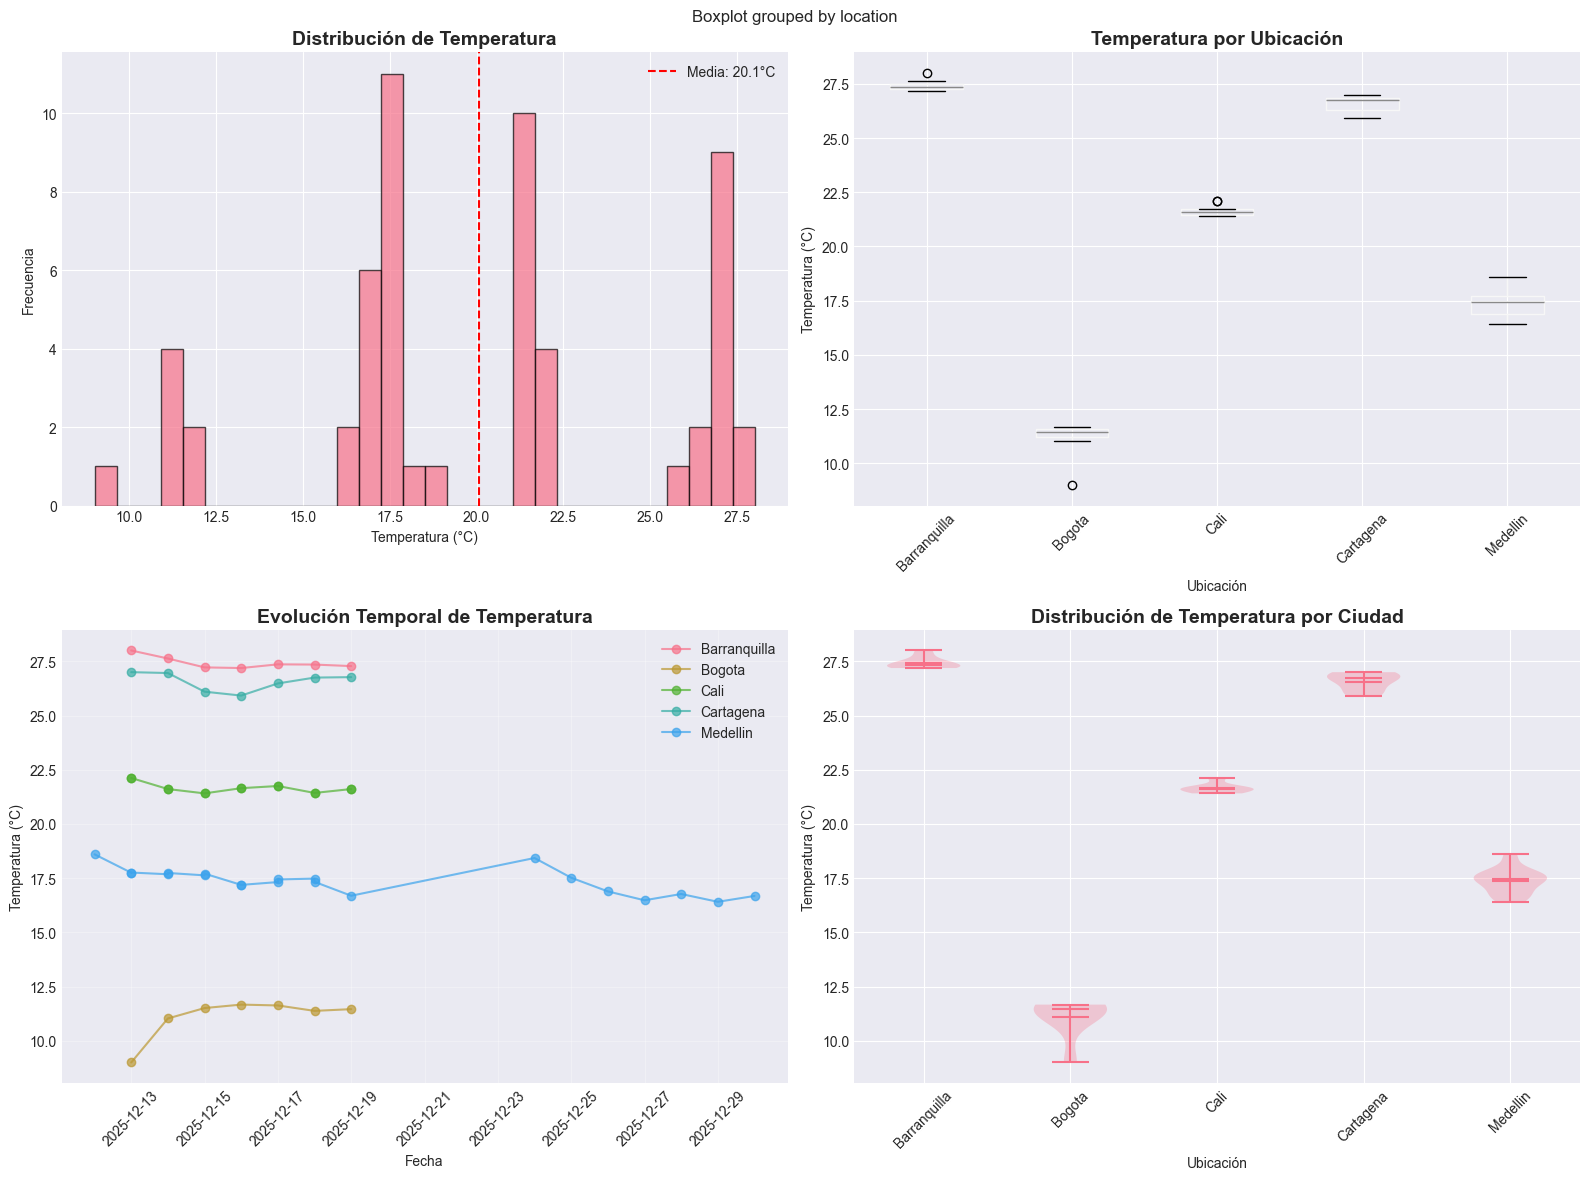

In [9]:
# Visualización: Distribución de temperatura
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histograma
axes[0, 0].hist(df['temperature_C'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Temperatura', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temperatura (°C)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(df['temperature_C'].mean(), color='red', linestyle='--', label=f'Media: {df["temperature_C"].mean():.1f}°C')
axes[0, 0].legend()

# Boxplot por ubicación
df.boxplot(column='temperature_C', by='location', ax=axes[0, 1])
axes[0, 1].set_title('Temperatura por Ubicación', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Ubicación')
axes[0, 1].set_ylabel('Temperatura (°C)')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

# Serie temporal
for location in df['location'].unique():
    df_loc = df[df['location'] == location].sort_values('timestamp')
    axes[1, 0].plot(df_loc['timestamp'], df_loc['temperature_C'], marker='o', label=location, alpha=0.7)

axes[1, 0].set_title('Evolución Temporal de Temperatura', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Temperatura (°C)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

# Violin plot
locations = df['location'].unique()
data_violin = [df[df['location'] == loc]['temperature_C'].dropna() for loc in locations]
axes[1, 1].violinplot(data_violin, showmeans=True, showmedians=True)
axes[1, 1].set_title('Distribución de Temperatura por Ciudad', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Ubicación')
axes[1, 1].set_ylabel('Temperatura (°C)')
axes[1, 1].set_xticks(range(1, len(locations) + 1))
axes[1, 1].set_xticklabels(locations, rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Gráfico interactivo de temperatura
fig = px.line(df.sort_values('timestamp'), 
              x='timestamp', 
              y='temperature_C', 
              color='location',
              title='📈 Temperatura a lo largo del tiempo',
              labels={'temperature_C': 'Temperatura (°C)', 'timestamp': 'Fecha'},
              template='plotly_white')

fig.update_layout(height=500, hovermode='x unified')
fig.show()

## 💨 5. VELOCIDAD DEL VIENTO

In [11]:
print("="*70)
print("ANÁLISIS DE VELOCIDAD DEL VIENTO")
print("="*70)

if 'windspeed_ms' in df.columns:
    wind = df['windspeed_ms'].dropna()
    
    print(f"\n📊 Estadísticas Generales:")
    print(f"  • Promedio: {wind.mean():.2f} m/s")
    print(f"  • Mínima: {wind.min():.2f} m/s")
    print(f"  • Máxima: {wind.max():.2f} m/s")
    print(f"  • Desviación estándar: {wind.std():.2f} m/s")
    
    # Convertir a km/h
    print(f"\n  En km/h:")
    print(f"  • Promedio: {wind.mean() * 3.6:.2f} km/h")
    print(f"  • Máxima: {wind.max() * 3.6:.2f} km/h")
    
    print(f"\n📍 Por Ubicación:")
    for location in sorted(df['location'].unique()):
        df_loc = df[df['location'] == location]
        wind_loc = df_loc['windspeed_ms'].dropna()
        
        if len(wind_loc) > 0:
            print(f"  {location}:")
            print(f"    - Promedio: {wind_loc.mean():.2f} m/s ({wind_loc.mean()*3.6:.1f} km/h)")
            print(f"    - Máxima: {wind_loc.max():.2f} m/s ({wind_loc.max()*3.6:.1f} km/h)")

ANÁLISIS DE VELOCIDAD DEL VIENTO

📊 Estadísticas Generales:
  • Promedio: 1.73 m/s
  • Mínima: 0.90 m/s
  • Máxima: 3.75 m/s
  • Desviación estándar: 0.76 m/s

  En km/h:
  • Promedio: 6.24 km/h
  • Máxima: 13.50 km/h

📍 Por Ubicación:
  Barranquilla:
    - Promedio: 3.18 m/s (11.4 km/h)
    - Máxima: 3.75 m/s (13.5 km/h)
  Bogota:
    - Promedio: 2.17 m/s (7.8 km/h)
    - Máxima: 2.31 m/s (8.3 km/h)
  Cali:
    - Promedio: 0.98 m/s (3.5 km/h)
    - Máxima: 1.09 m/s (3.9 km/h)
  Cartagena:
    - Promedio: 2.27 m/s (8.2 km/h)
    - Máxima: 2.81 m/s (10.1 km/h)
  Medellin:
    - Promedio: 1.43 m/s (5.1 km/h)
    - Máxima: 2.03 m/s (7.3 km/h)


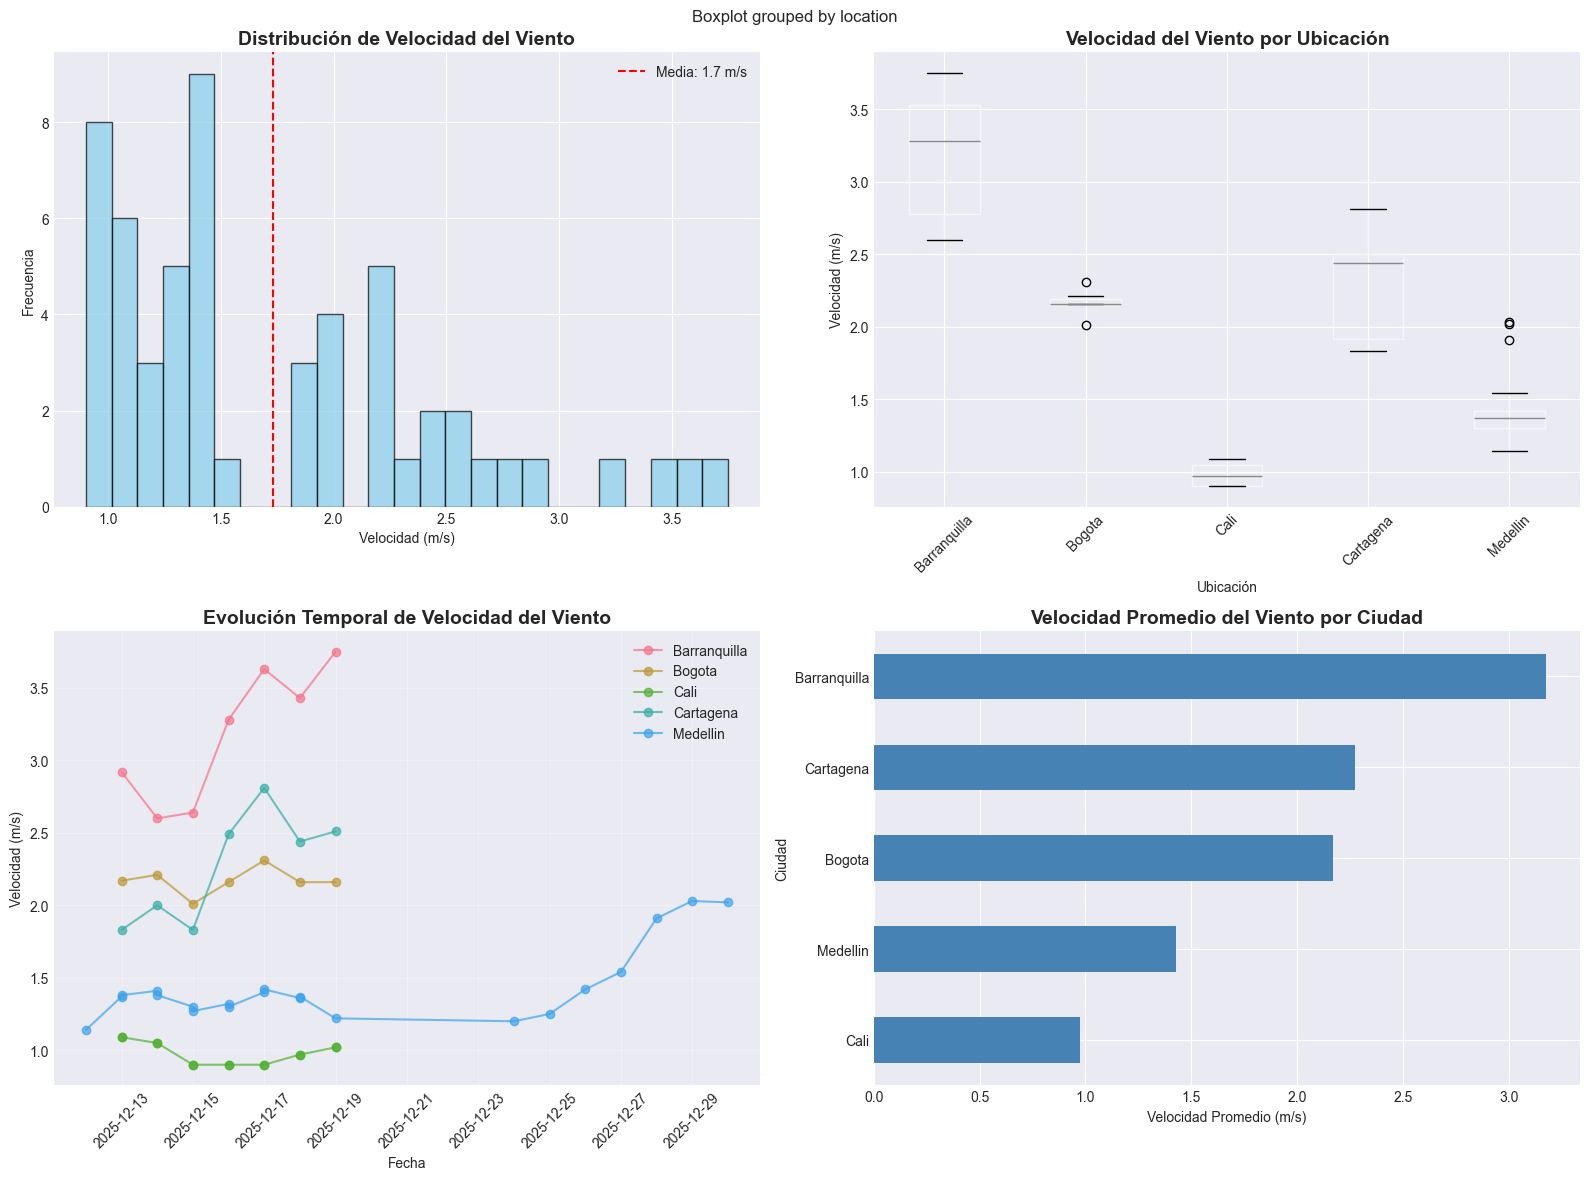

In [12]:
# Visualización: Velocidad del viento
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histograma
axes[0, 0].hist(df['windspeed_ms'].dropna(), bins=25, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribución de Velocidad del Viento', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Velocidad (m/s)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(df['windspeed_ms'].mean(), color='red', linestyle='--', label=f'Media: {df["windspeed_ms"].mean():.1f} m/s')
axes[0, 0].legend()

# Boxplot por ubicación
df.boxplot(column='windspeed_ms', by='location', ax=axes[0, 1])
axes[0, 1].set_title('Velocidad del Viento por Ubicación', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Ubicación')
axes[0, 1].set_ylabel('Velocidad (m/s)')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

# Serie temporal
for location in df['location'].unique():
    df_loc = df[df['location'] == location].sort_values('timestamp')
    axes[1, 0].plot(df_loc['timestamp'], df_loc['windspeed_ms'], marker='o', label=location, alpha=0.7)

axes[1, 0].set_title('Evolución Temporal de Velocidad del Viento', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Velocidad (m/s)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

# Promedio por ciudad (barras)
wind_avg = df.groupby('location')['windspeed_ms'].mean().sort_values()
wind_avg.plot(kind='barh', ax=axes[1, 1], color='steelblue')
axes[1, 1].set_title('Velocidad Promedio del Viento por Ciudad', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Velocidad Promedio (m/s)')
axes[1, 1].set_ylabel('Ciudad')

plt.tight_layout()
plt.show()

## ⏲️ 6. PRESIÓN ATMOSFÉRICA

In [13]:
print("="*70)
print("ANÁLISIS DE PRESIÓN ATMOSFÉRICA")
print("="*70)

if 'pressure_hPa' in df.columns:
    pressure = df['pressure_hPa'].dropna()
    
    if len(pressure) > 0:
        print(f"\n📊 Estadísticas Generales:")
        print(f"  • Promedio: {pressure.mean():.2f} hPa")
        print(f"  • Mínima: {pressure.min():.2f} hPa")
        print(f"  • Máxima: {pressure.max():.2f} hPa")
        print(f"  • Desviación estándar: {pressure.std():.2f} hPa")
        print(f"  • Rango: {pressure.max() - pressure.min():.2f} hPa")
        
        print(f"\n📍 Por Ubicación:")
        for location in sorted(df['location'].unique()):
            df_loc = df[df['location'] == location]
            press_loc = df_loc['pressure_hPa'].dropna()
            
            if len(press_loc) > 0:
                print(f"  {location}:")
                print(f"    - Promedio: {press_loc.mean():.2f} hPa")
                print(f"    - Rango: {press_loc.min():.2f} - {press_loc.max():.2f} hPa")
    else:
        print("\n⚠️  No hay datos de presión disponibles")

ANÁLISIS DE PRESIÓN ATMOSFÉRICA

📊 Estadísticas Generales:
  • Promedio: 1011.79 hPa
  • Mínima: 1008.00 hPa
  • Máxima: 1015.00 hPa
  • Desviación estándar: 2.16 hPa
  • Rango: 7.00 hPa

📍 Por Ubicación:
  Barranquilla:
    - Promedio: 1008.57 hPa
    - Rango: 1008.00 - 1009.00 hPa
  Bogota:
    - Promedio: 1015.00 hPa
    - Rango: 1015.00 - 1015.00 hPa
  Cali:
    - Promedio: 1011.57 hPa
    - Rango: 1011.00 - 1012.00 hPa
  Cartagena:
    - Promedio: 1008.71 hPa
    - Rango: 1008.00 - 1009.00 hPa
  Medellin:
    - Promedio: 1012.95 hPa
    - Rango: 1012.00 - 1014.00 hPa


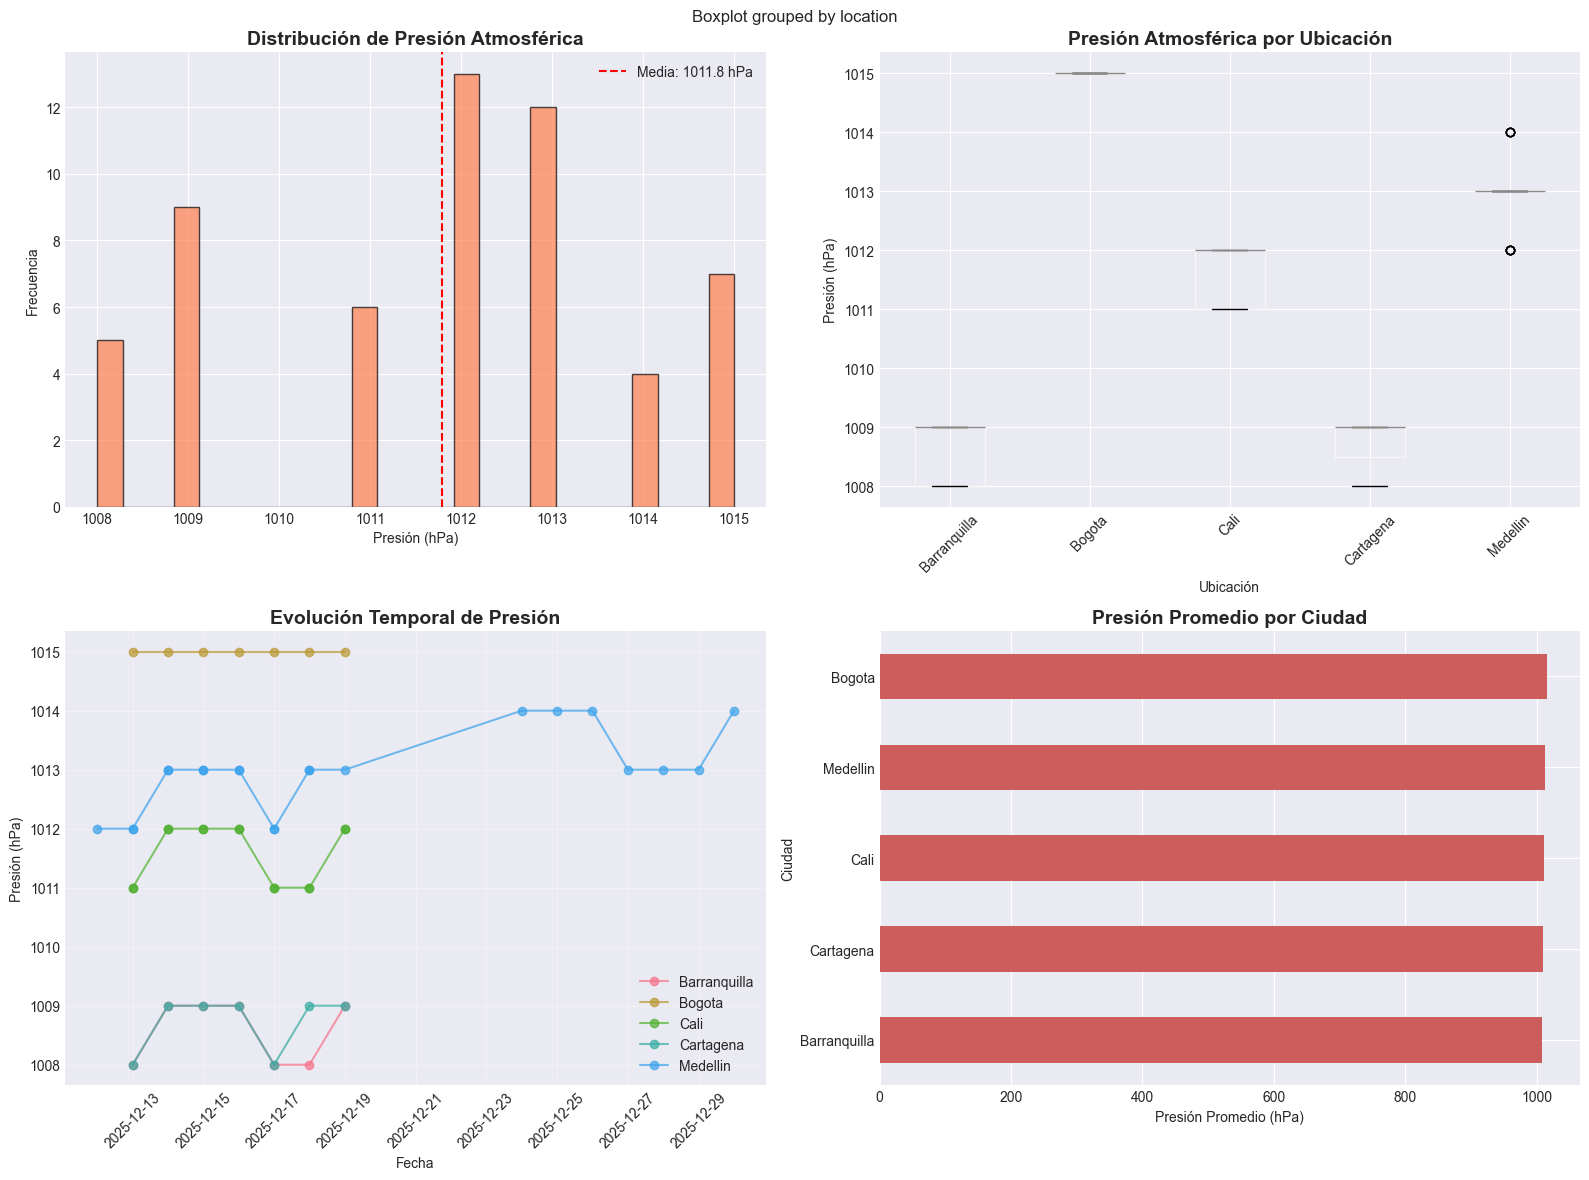

In [14]:
# Visualización: Presión atmosférica
if 'pressure_hPa' in df.columns and df['pressure_hPa'].notna().sum() > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histograma
    axes[0, 0].hist(df['pressure_hPa'].dropna(), bins=25, edgecolor='black', alpha=0.7, color='coral')
    axes[0, 0].set_title('Distribución de Presión Atmosférica', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Presión (hPa)')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].axvline(df['pressure_hPa'].mean(), color='red', linestyle='--', 
                       label=f'Media: {df["pressure_hPa"].mean():.1f} hPa')
    axes[0, 0].legend()
    
    # Boxplot por ubicación
    df.boxplot(column='pressure_hPa', by='location', ax=axes[0, 1])
    axes[0, 1].set_title('Presión Atmosférica por Ubicación', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Ubicación')
    axes[0, 1].set_ylabel('Presión (hPa)')
    plt.sca(axes[0, 1])
    plt.xticks(rotation=45)
    
    # Serie temporal
    for location in df['location'].unique():
        df_loc = df[df['location'] == location].sort_values('timestamp')
        if df_loc['pressure_hPa'].notna().sum() > 0:
            axes[1, 0].plot(df_loc['timestamp'], df_loc['pressure_hPa'], 
                           marker='o', label=location, alpha=0.7)
    
    axes[1, 0].set_title('Evolución Temporal de Presión', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Presión (hPa)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Promedio por ciudad
    press_avg = df.groupby('location')['pressure_hPa'].mean().sort_values()
    press_avg.plot(kind='barh', ax=axes[1, 1], color='indianred')
    axes[1, 1].set_title('Presión Promedio por Ciudad', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Presión Promedio (hPa)')
    axes[1, 1].set_ylabel('Ciudad')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No hay datos de presión para visualizar")

## 🌧️ 7. PRECIPITACIÓN

In [15]:
print("="*70)
print("ANÁLISIS DE PRECIPITACIÓN")
print("="*70)

if 'precipitation_mm' in df.columns:
    precip = df['precipitation_mm'].dropna()
    
    print(f"\n📊 Estadísticas Generales:")
    print(f"  • Total acumulado: {precip.sum():.2f} mm")
    print(f"  • Promedio diario: {precip.mean():.2f} mm")
    print(f"  • Máxima: {precip.max():.2f} mm")
    print(f"  • Días con lluvia (>0mm): {(precip > 0).sum()} de {len(precip)}")
    print(f"  • Porcentaje días lluviosos: {100 * (precip > 0).sum() / len(precip):.1f}%")
    
    print(f"\n📍 Por Ubicación:")
    for location in sorted(df['location'].unique()):
        df_loc = df[df['location'] == location]
        precip_loc = df_loc['precipitation_mm'].dropna()
        
        if len(precip_loc) > 0:
            print(f"  {location}:")
            print(f"    - Total: {precip_loc.sum():.2f} mm")
            print(f"    - Promedio: {precip_loc.mean():.2f} mm/día")
            print(f"    - Días lluviosos: {(precip_loc > 0).sum()} ({100*(precip_loc > 0).sum()/len(precip_loc):.1f}%)")

ANÁLISIS DE PRECIPITACIÓN

📊 Estadísticas Generales:
  • Total acumulado: 109.84 mm
  • Promedio diario: 1.96 mm
  • Máxima: 10.41 mm
  • Días con lluvia (>0mm): 41 de 56
  • Porcentaje días lluviosos: 73.2%

📍 Por Ubicación:
  Barranquilla:
    - Total: 1.10 mm
    - Promedio: 0.16 mm/día
    - Días lluviosos: 1 (14.3%)
  Bogota:
    - Total: 0.82 mm
    - Promedio: 0.12 mm/día
    - Días lluviosos: 2 (28.6%)
  Cali:
    - Total: 39.86 mm
    - Promedio: 2.85 mm/día
    - Días lluviosos: 12 (85.7%)
  Cartagena:
    - Total: 17.11 mm
    - Promedio: 2.44 mm/día
    - Días lluviosos: 7 (100.0%)
  Medellin:
    - Total: 50.95 mm
    - Promedio: 2.43 mm/día
    - Días lluviosos: 19 (90.5%)


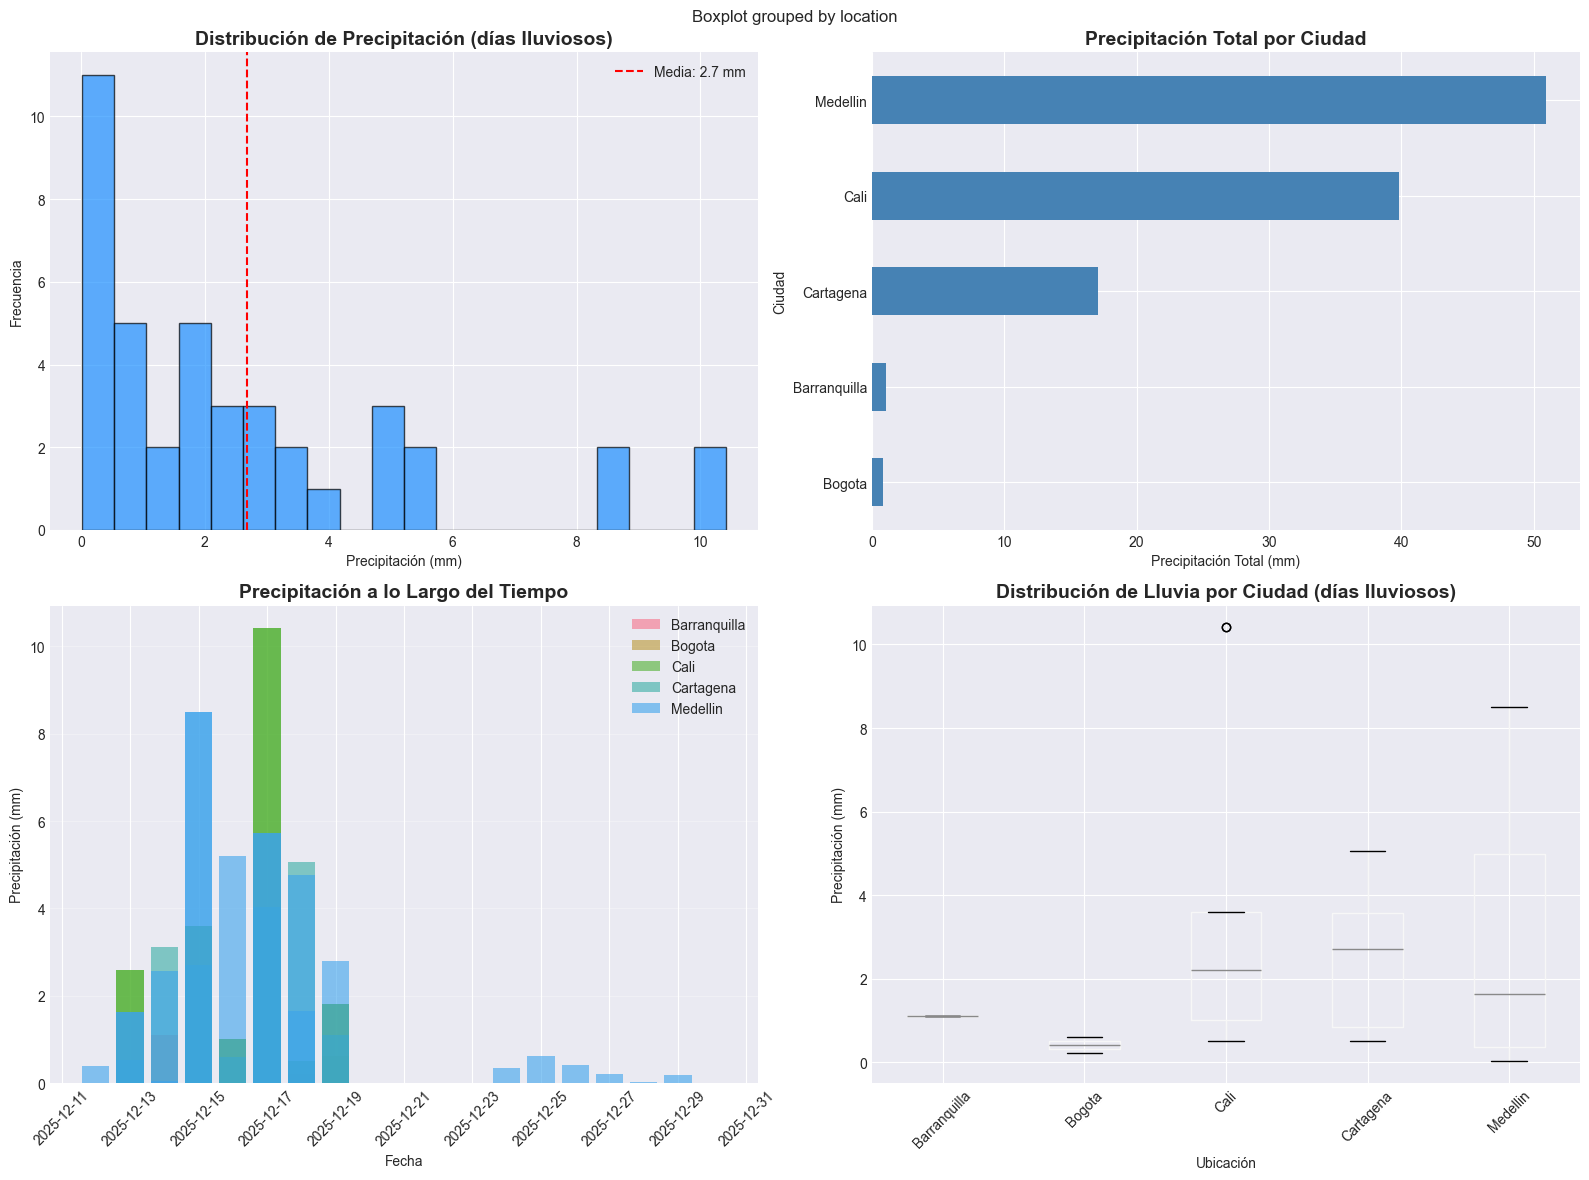

In [16]:
# Visualización: Precipitación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histograma (solo días con lluvia)
rain_data = df[df['precipitation_mm'] > 0]['precipitation_mm']
if len(rain_data) > 0:
    axes[0, 0].hist(rain_data, bins=20, edgecolor='black', alpha=0.7, color='dodgerblue')
    axes[0, 0].set_title('Distribución de Precipitación (días lluviosos)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Precipitación (mm)')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].axvline(rain_data.mean(), color='red', linestyle='--', 
                       label=f'Media: {rain_data.mean():.1f} mm')
    axes[0, 0].legend()
else:
    axes[0, 0].text(0.5, 0.5, 'Sin datos de lluvia', ha='center', va='center')

# Precipitación total por ciudad
precip_total = df.groupby('location')['precipitation_mm'].sum().sort_values()
precip_total.plot(kind='barh', ax=axes[0, 1], color='steelblue')
axes[0, 1].set_title('Precipitación Total por Ciudad', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Precipitación Total (mm)')
axes[0, 1].set_ylabel('Ciudad')

# Serie temporal
for location in df['location'].unique():
    df_loc = df[df['location'] == location].sort_values('timestamp')
    axes[1, 0].bar(df_loc['timestamp'], df_loc['precipitation_mm'], 
                   label=location, alpha=0.6, width=0.8)

axes[1, 0].set_title('Precipitación a lo Largo del Tiempo', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Precipitación (mm)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

# Boxplot por ubicación
df[df['precipitation_mm'] > 0].boxplot(column='precipitation_mm', by='location', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Lluvia por Ciudad (días lluviosos)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Ubicación')
axes[1, 1].set_ylabel('Precipitación (mm)')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 💧 8. HUMEDAD RELATIVA

In [17]:
print("="*70)
print("ANÁLISIS DE HUMEDAD RELATIVA")
print("="*70)

if 'humidity_percent' in df.columns:
    humidity = df['humidity_percent'].dropna()
    
    if len(humidity) > 0:
        print(f"\n📊 Estadísticas Generales:")
        print(f"  • Promedio: {humidity.mean():.2f}%")
        print(f"  • Mínima: {humidity.min():.2f}%")
        print(f"  • Máxima: {humidity.max():.2f}%")
        print(f"  • Desviación estándar: {humidity.std():.2f}%")
        
        print(f"\n📍 Por Ubicación:")
        for location in sorted(df['location'].unique()):
            df_loc = df[df['location'] == location]
            hum_loc = df_loc['humidity_percent'].dropna()
            
            if len(hum_loc) > 0:
                print(f"  {location}:")
                print(f"    - Promedio: {hum_loc.mean():.2f}%")
                print(f"    - Rango: {hum_loc.min():.2f} - {hum_loc.max():.2f}%")
    else:
        print("\n⚠️  No hay datos de humedad disponibles")

ANÁLISIS DE HUMEDAD RELATIVA

📊 Estadísticas Generales:
  • Promedio: 75.25%
  • Mínima: 68.00%
  • Máxima: 83.00%
  • Desviación estándar: 4.35%

📍 Por Ubicación:
  Barranquilla:
    - Promedio: 79.00%
    - Rango: 77.00 - 81.00%
  Bogota:
    - Promedio: 79.71%
    - Rango: 78.00 - 82.00%
  Cali:
    - Promedio: 70.86%
    - Rango: 69.00 - 73.00%
  Cartagena:
    - Promedio: 80.57%
    - Rango: 78.00 - 83.00%
  Medellin:
    - Promedio: 73.67%
    - Rango: 68.00 - 82.00%


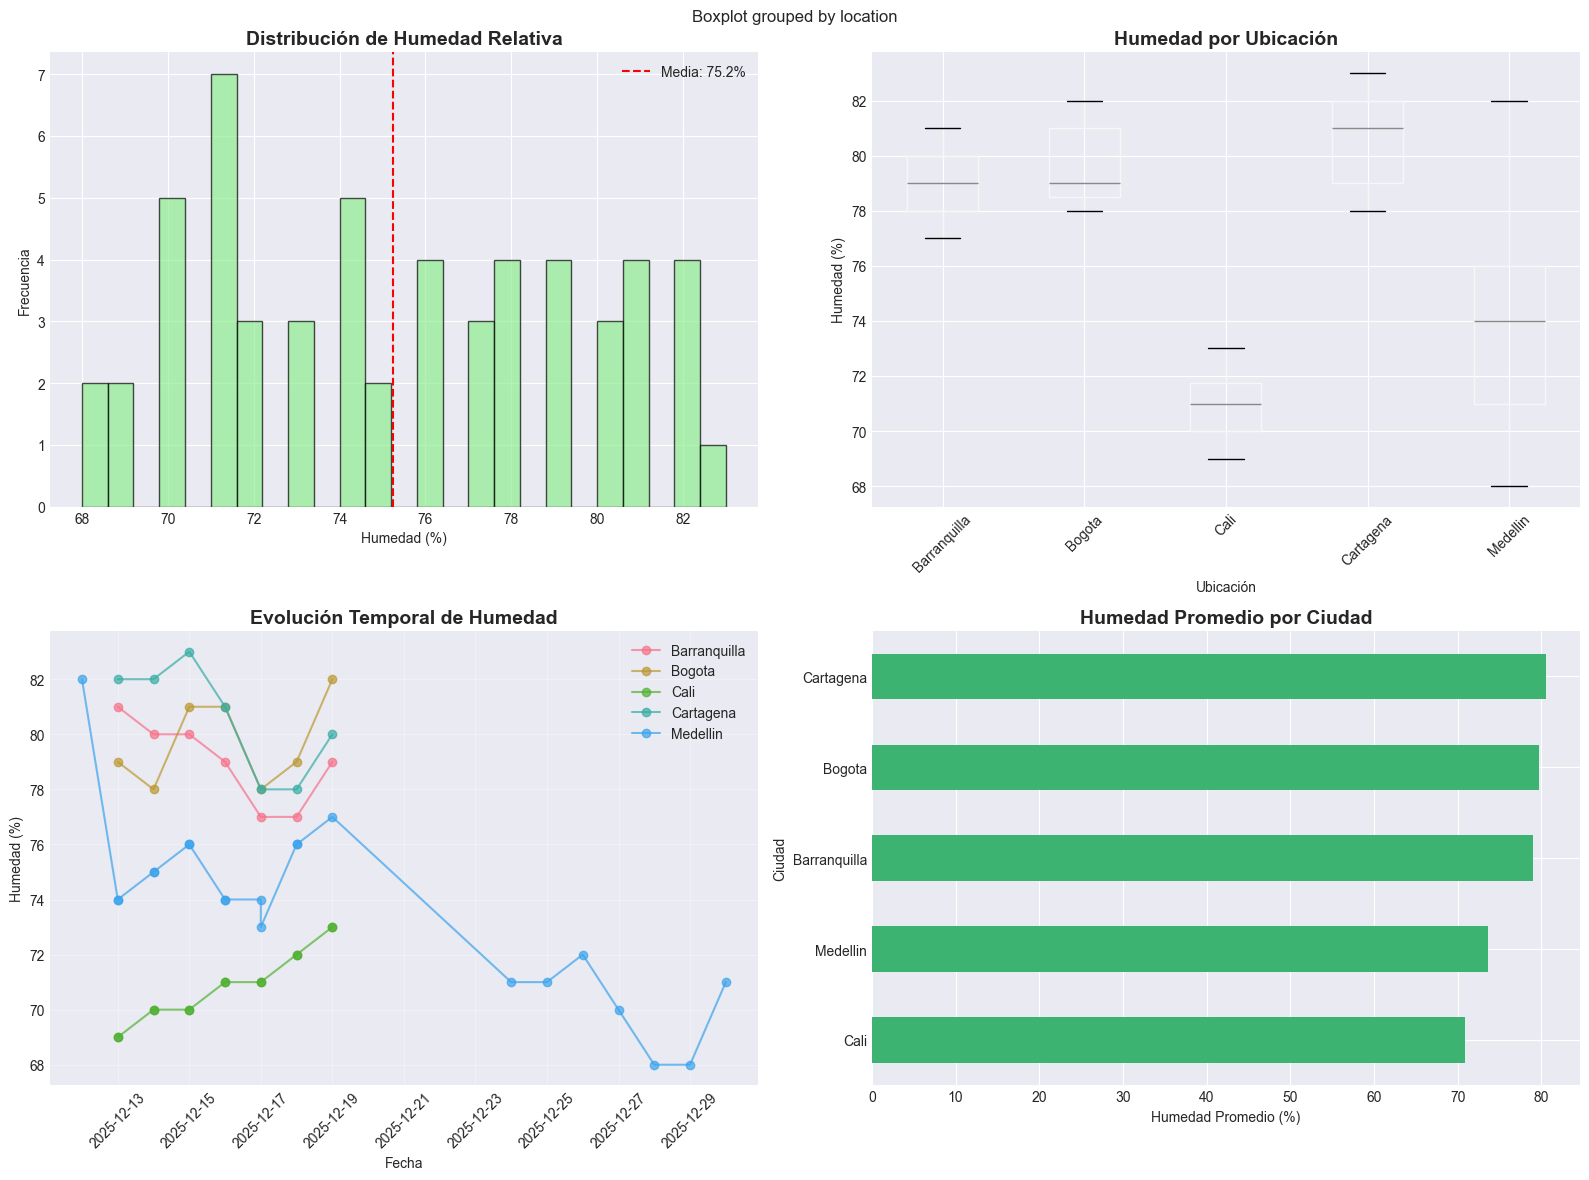

In [18]:
# Visualización: Humedad
if 'humidity_percent' in df.columns and df['humidity_percent'].notna().sum() > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histograma
    axes[0, 0].hist(df['humidity_percent'].dropna(), bins=25, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[0, 0].set_title('Distribución de Humedad Relativa', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Humedad (%)')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].axvline(df['humidity_percent'].mean(), color='red', linestyle='--', 
                       label=f'Media: {df["humidity_percent"].mean():.1f}%')
    axes[0, 0].legend()
    
    # Boxplot por ubicación
    df.boxplot(column='humidity_percent', by='location', ax=axes[0, 1])
    axes[0, 1].set_title('Humedad por Ubicación', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Ubicación')
    axes[0, 1].set_ylabel('Humedad (%)')
    plt.sca(axes[0, 1])
    plt.xticks(rotation=45)
    
    # Serie temporal
    for location in df['location'].unique():
        df_loc = df[df['location'] == location].sort_values('timestamp')
        if df_loc['humidity_percent'].notna().sum() > 0:
            axes[1, 0].plot(df_loc['timestamp'], df_loc['humidity_percent'], 
                           marker='o', label=location, alpha=0.7)
    
    axes[1, 0].set_title('Evolución Temporal de Humedad', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Humedad (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Promedio por ciudad
    hum_avg = df.groupby('location')['humidity_percent'].mean().sort_values()
    hum_avg.plot(kind='barh', ax=axes[1, 1], color='mediumseagreen')
    axes[1, 1].set_title('Humedad Promedio por Ciudad', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Humedad Promedio (%)')
    axes[1, 1].set_ylabel('Ciudad')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No hay datos de humedad para visualizar")

---
# 🔗 CORRELACIONES ENTRE VARIABLES
---

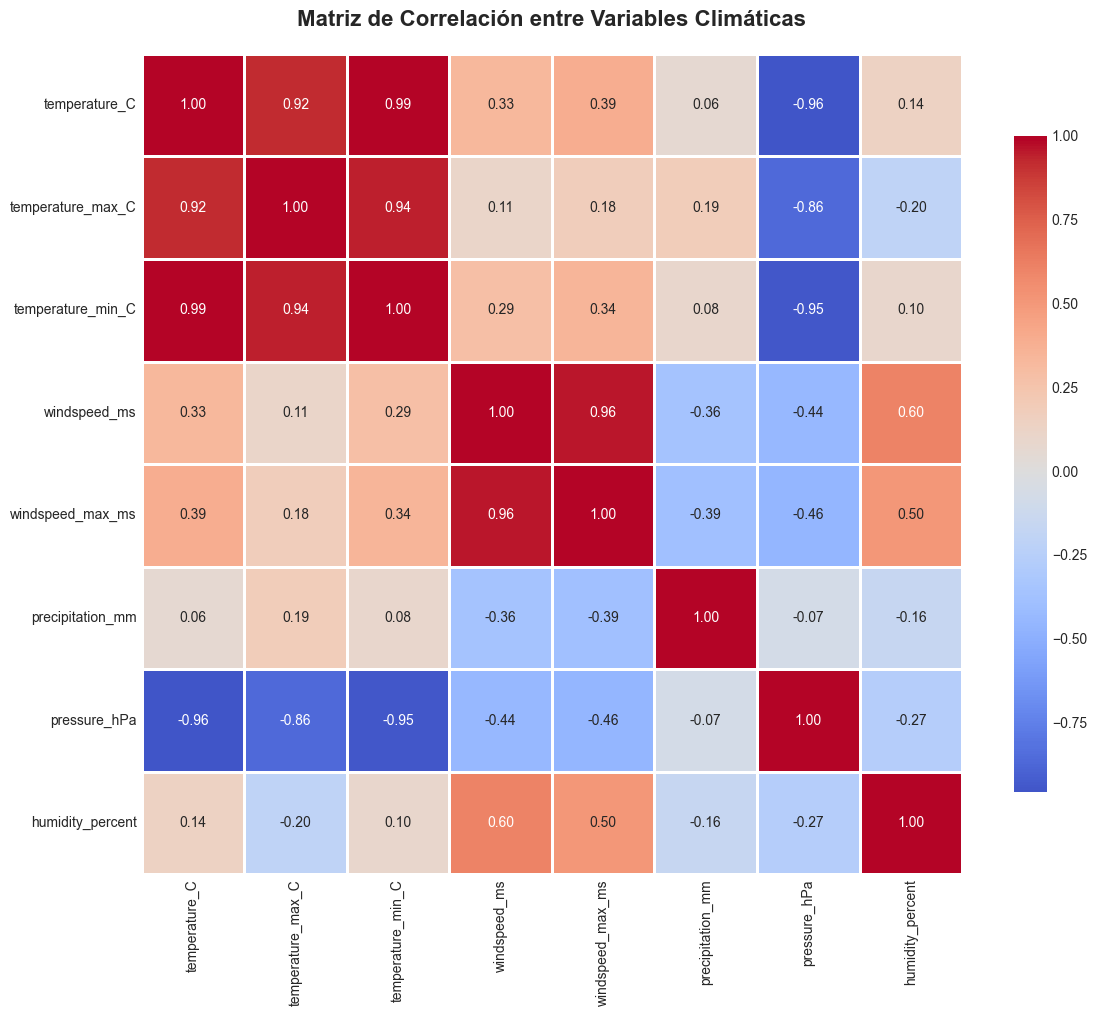


📊 Correlaciones más fuertes:
  temperature_C ↔ temperature_min_C: 0.994
  temperature_C ↔ pressure_hPa: -0.959
  windspeed_ms ↔ windspeed_max_ms: 0.956
  temperature_min_C ↔ pressure_hPa: -0.951
  temperature_max_C ↔ temperature_min_C: 0.941
  temperature_C ↔ temperature_max_C: 0.922
  temperature_max_C ↔ pressure_hPa: -0.860
  windspeed_ms ↔ humidity_percent: 0.603
  windspeed_max_ms ↔ humidity_percent: 0.503
  windspeed_max_ms ↔ pressure_hPa: -0.458


In [19]:
# Matriz de correlación
numeric_cols = df.select_dtypes(include=['number']).columns

if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    
    # Visualización con heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de Correlación entre Variables Climáticas', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Correlaciones más fuertes:")
    # Obtener correlaciones únicas
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))
    
    # Ordenar por valor absoluto
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for var1, var2, corr in corr_pairs[:10]:
        print(f"  {var1} ↔ {var2}: {corr:.3f}")

In [21]:
%pip install -q statsmodels

# Scatter plots de las correlaciones más interesantes
if 'temperature_C' in df.columns and 'humidity_percent' in df.columns:
    fig = px.scatter(df, x='temperature_C', y='humidity_percent', color='location',
                     title='Relación Temperatura vs Humedad',
                     labels={'temperature_C': 'Temperatura (°C)', 
                            'humidity_percent': 'Humedad (%)'},
                     trendline='ols',
                     template='plotly_white')
    fig.update_layout(height=500)
    fig.show()

Note: you may need to restart the kernel to use updated packages.


---
# 📊 COMPARACIÓN ENTRE CIUDADES
---


📍 RESUMEN POR CIUDAD
              temperature_C  windspeed_ms  precipitation_mm  humidity_percent  \
location                                                                        
Barranquilla          27.43          3.18              1.10             79.00   
Bogota                11.10          2.17              0.82             79.71   
Cali                  21.65          0.98             39.86             70.86   
Cartagena             26.57          2.27             17.11             80.57   
Medellin              17.37          1.43             50.95             73.67   

              pressure_hPa  
location                    
Barranquilla       1008.57  
Bogota             1015.00  
Cali               1011.57  
Cartagena          1008.71  
Medellin           1012.95  


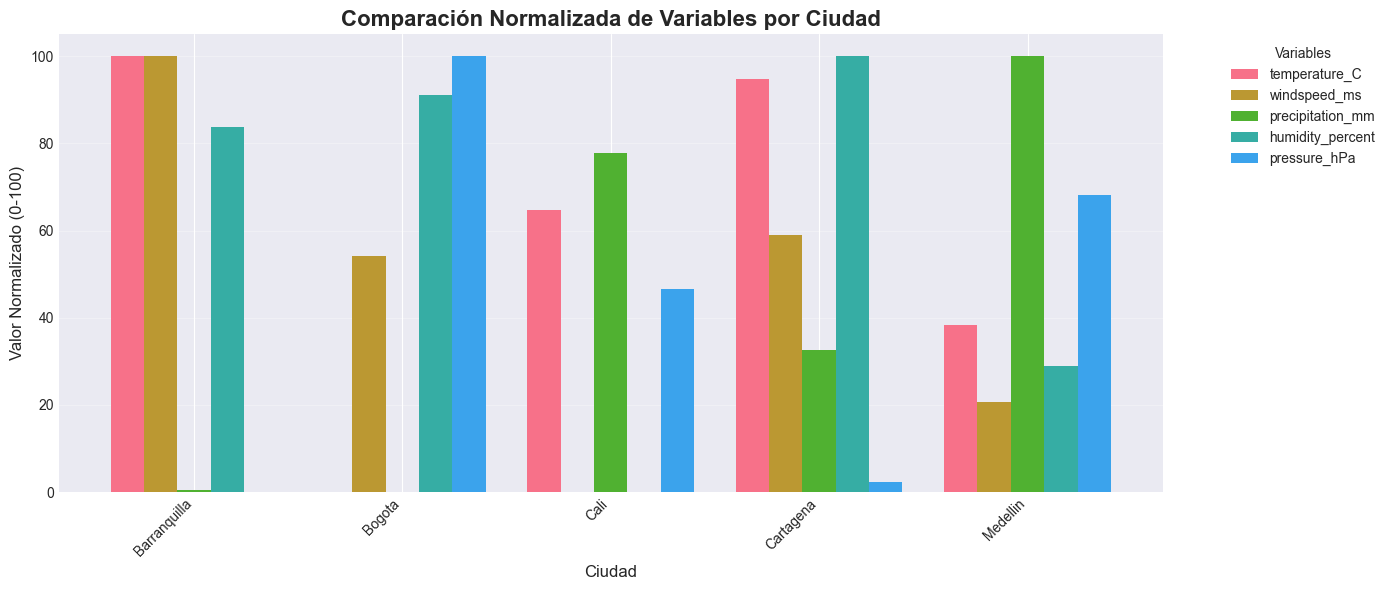

In [22]:
# Radar chart comparando ciudades
from math import pi

# Preparar datos
summary = df.groupby('location').agg({
    'temperature_C': 'mean',
    'windspeed_ms': 'mean',
    'precipitation_mm': 'sum',
    'humidity_percent': 'mean',
    'pressure_hPa': 'mean'
}).fillna(0)

# Normalizar valores (0-100)
summary_norm = summary.copy()
for col in summary_norm.columns:
    if summary_norm[col].max() > 0:
        summary_norm[col] = 100 * (summary_norm[col] - summary_norm[col].min()) / (summary_norm[col].max() - summary_norm[col].min())

print("\n📍 RESUMEN POR CIUDAD")
print("="*70)
print(summary.round(2))

# Gráfico de barras agrupadas
summary_norm.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title('Comparación Normalizada de Variables por Ciudad', fontsize=16, fontweight='bold')
plt.xlabel('Ciudad', fontsize=12)
plt.ylabel('Valor Normalizado (0-100)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---
# 💾 EXPORTAR RESULTADOS
---

In [23]:
# Guardar datos procesados
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# CSV
csv_path = output_dir / 'datos_climaticos_completos.csv'
df.to_csv(csv_path, index=False)
print(f"✓ Guardado CSV: {csv_path}")

# Resumen estadístico
summary_path = output_dir / 'resumen_estadistico.csv'
summary.to_csv(summary_path)
print(f"✓ Guardado resumen: {summary_path}")

# Parquet (si está disponible)
try:
    parquet_path = output_dir / 'datos_climaticos_completos.parquet'
    df.to_parquet(parquet_path, index=False)
    print(f"✓ Guardado Parquet: {parquet_path}")
except:
    print("⚠️  Parquet no disponible (pip install pyarrow)")

print(f"\n✓ Análisis completado. Archivos en: {output_dir}")

✓ Guardado CSV: ..\data\processed\datos_climaticos_completos.csv
✓ Guardado resumen: ..\data\processed\resumen_estadistico.csv
✓ Guardado Parquet: ..\data\processed\datos_climaticos_completos.parquet

✓ Análisis completado. Archivos en: ..\data\processed


---
# 🎯 CONCLUSIONES
---

In [24]:
print("="*70)
print("CONCLUSIONES DEL ANÁLISIS")
print("="*70)

print(f"\n📊 Datos analizados:")
print(f"  • {len(df)} registros")
print(f"  • {df['location'].nunique()} ubicaciones")
print(f"  • {df['source'].nunique()} fuentes de datos")
print(f"  • Período: {(df['timestamp'].max() - df['timestamp'].min()).days} días")

print(f"\n🌡️  Temperatura:")
if 'temperature_C' in df.columns:
    print(f"  • Promedio general: {df['temperature_C'].mean():.1f}°C")
    temp_by_city = df.groupby('location')['temperature_C'].mean().sort_values()
    print(f"  • Ciudad más cálida: {temp_by_city.index[-1]} ({temp_by_city.iloc[-1]:.1f}°C)")
    print(f"  • Ciudad más fría: {temp_by_city.index[0]} ({temp_by_city.iloc[0]:.1f}°C)")

print(f"\n🌧️  Precipitación:")
if 'precipitation_mm' in df.columns:
    precip_by_city = df.groupby('location')['precipitation_mm'].sum().sort_values(ascending=False)
    print(f"  • Total acumulado: {df['precipitation_mm'].sum():.1f} mm")
    print(f"  • Ciudad más lluviosa: {precip_by_city.index[0]} ({precip_by_city.iloc[0]:.1f} mm)")
    print(f"  • % días con lluvia: {100 * (df['precipitation_mm'] > 0).sum() / len(df):.1f}%")

print(f"\n💨 Viento:")
if 'windspeed_ms' in df.columns:
    wind_by_city = df.groupby('location')['windspeed_ms'].mean().sort_values(ascending=False)
    print(f"  • Velocidad promedio: {df['windspeed_ms'].mean():.1f} m/s")
    print(f"  • Ciudad más ventosa: {wind_by_city.index[0]} ({wind_by_city.iloc[0]:.1f} m/s)")

print(f"\n📈 Próximos pasos sugeridos:")
print(f"  1. Análisis de series temporales")
print(f"  2. Predicción con Machine Learning")
print(f"  3. Dashboard interactivo con Streamlit")
print(f"  4. Análisis de tendencias estacionales")

print("\n" + "="*70)
print("✓ Análisis completado exitosamente")
print("="*70)

CONCLUSIONES DEL ANÁLISIS

📊 Datos analizados:
  • 56 registros
  • 5 ubicaciones
  • 1 fuentes de datos
  • Período: 18 días

🌡️  Temperatura:
  • Promedio general: 20.1°C
  • Ciudad más cálida: Barranquilla (27.4°C)
  • Ciudad más fría: Bogota (11.1°C)

🌧️  Precipitación:
  • Total acumulado: 109.8 mm
  • Ciudad más lluviosa: Medellin (51.0 mm)
  • % días con lluvia: 73.2%

💨 Viento:
  • Velocidad promedio: 1.7 m/s
  • Ciudad más ventosa: Barranquilla (3.2 m/s)

📈 Próximos pasos sugeridos:
  1. Análisis de series temporales
  2. Predicción con Machine Learning
  3. Dashboard interactivo con Streamlit
  4. Análisis de tendencias estacionales

✓ Análisis completado exitosamente
